<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install --quiet pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.5 MB/s eta 0:00:00


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul 19 23:22:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Getting the data

In [ ]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [ ]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [ ]:
FIGSIZE = (20, 20)

In [ ]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [ ]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [ ]:
dataset.shape

(346507, 2)

In [ ]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [ ]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [ ]:
dataset.isnull().sum()

date_time    0
level_cm     0
dtype: int64

In [ ]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [ ]:
dataset.dtypes

level_cm    int64
dtype: object

# Time Series EDA

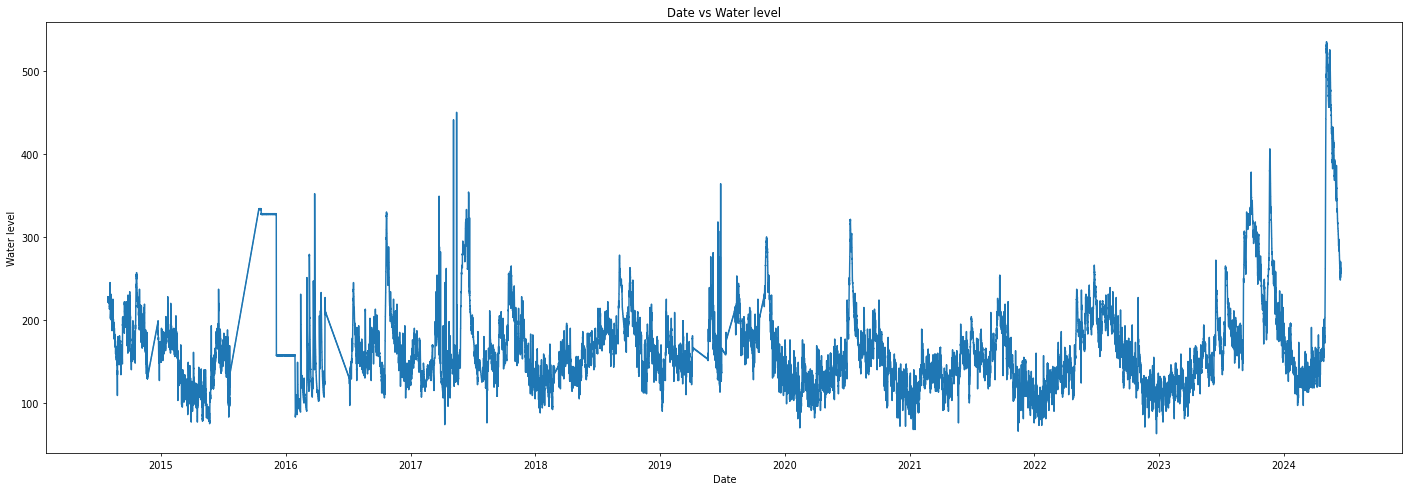

In [ ]:
plot_dataset(dataset.index, dataset['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Selecting time

In [ ]:
# Definir a faixa de datas
start_date = '2020-01-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

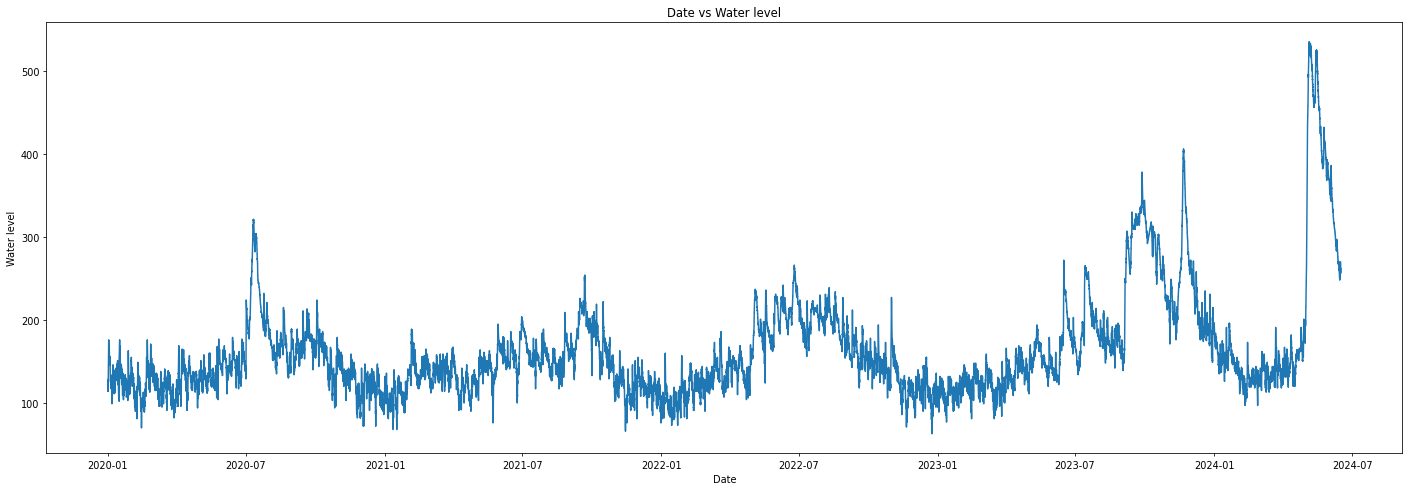

In [ ]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Grouping the data by day

In [ ]:
df_daily_mean = df_filtered.resample('D').mean()
df_daily_mean

,level_cm
date_time,
2020-01-01,133.281250
2020-01-02,168.656250
2020-01-03,152.645833
2020-01-04,131.593750
2020-01-05,125.791667
...,...
2024-06-12,270.854167
2024-06-13,263.791667
2024-06-14,252.802083


## Time Series Decomposition

In [ ]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

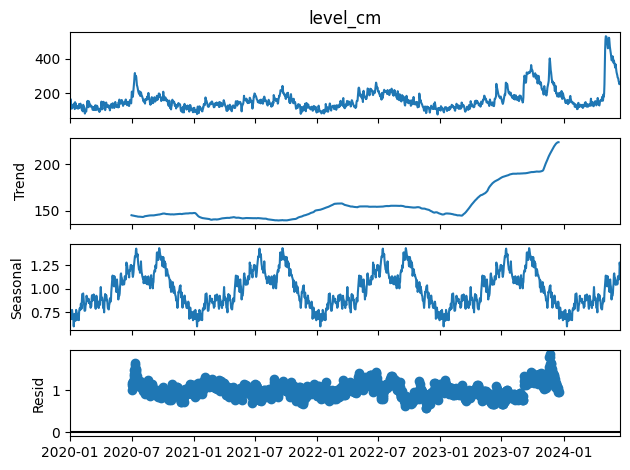

In [ ]:
result = seasonal_decompose(df_daily_mean['level_cm'], model='multiplicative', period=365)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

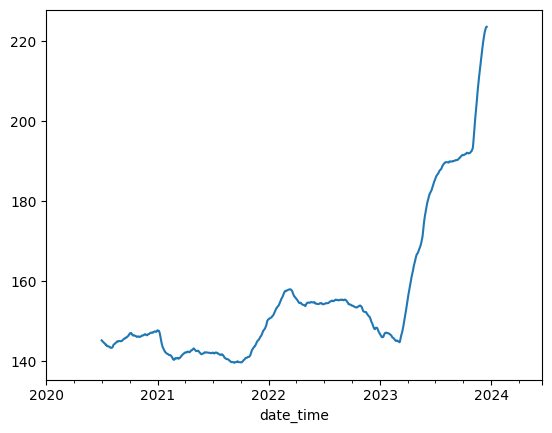

In [ ]:
result.trend.plot()

<Axes: xlabel='date_time'>

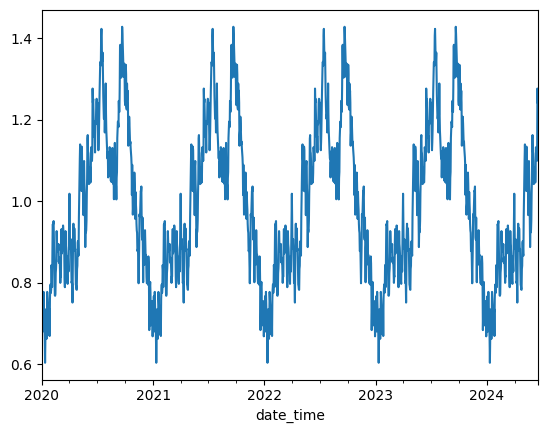

In [ ]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

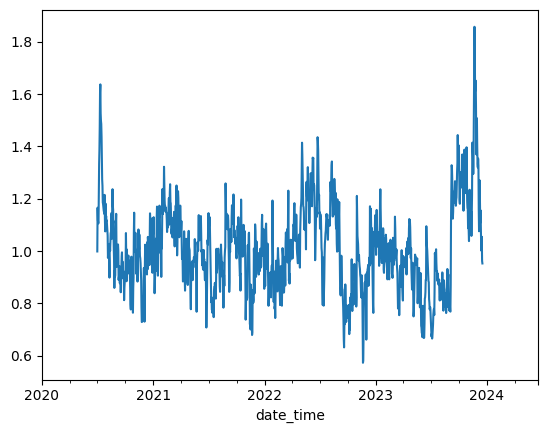

In [ ]:
residual = result.resid
residual.plot()

## Making the series stationary

In [ ]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [ ]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [ ]:
print("Level_cm")
check_stationarity(df_daily_mean['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.273927
p-value: 0.000493
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


### Transforming data

In [ ]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_daily_mean['level_cm'] - df_daily_mean['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2020-01-02,35.375000
2020-01-03,-16.010417
2020-01-04,-21.052083
2020-01-05,-5.802083
2020-01-06,-13.593750
...,...
2024-06-12,-12.781250
2024-06-13,-7.062500
2024-06-14,-10.989583


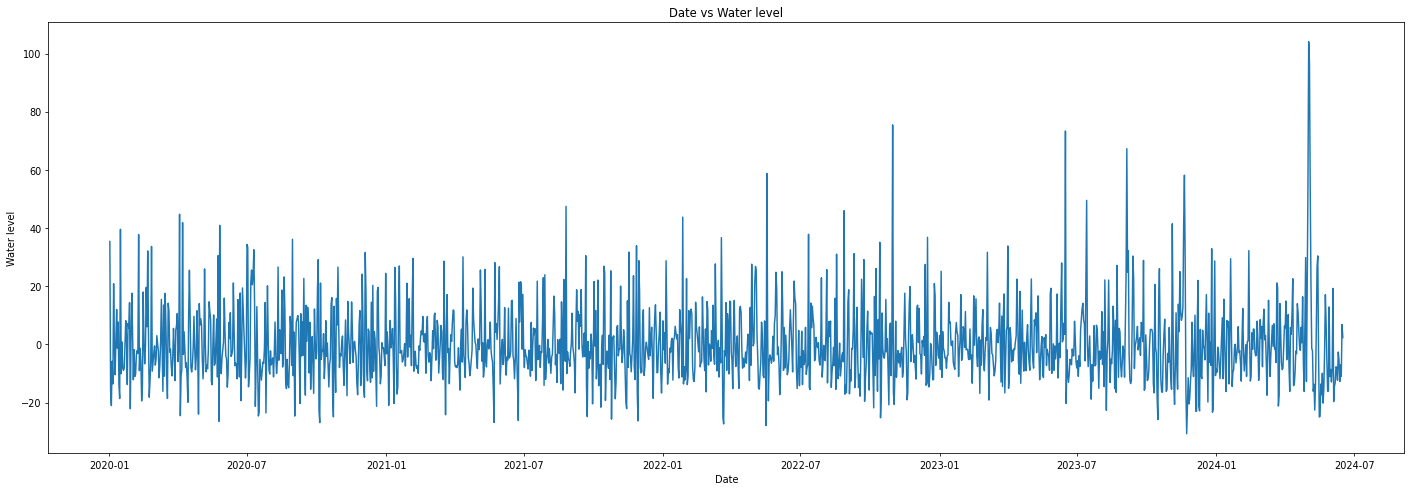

In [ ]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [ ]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -29.888928
p-value: 0.000000
Critical values: 
	1%: -3.434378
	5%: -2.863319
	10%: -2.567717


**Using ACF and PACF level_cm**

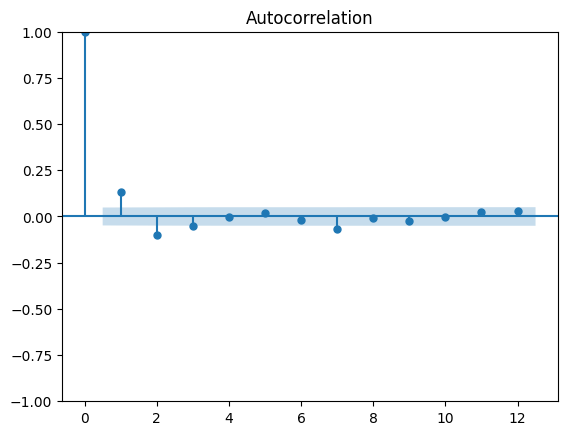

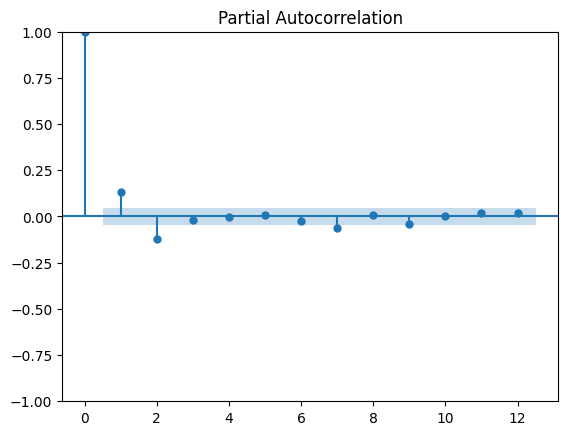

In [ ]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

# Training the model

## Scaling the data

In [ ]:
data = df_lag['level_cm_lag_1'].values
data

array([ 35.375     , -16.01041667, -21.05208333, ..., -10.98958333,
         6.83333333,   2.36458333])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
data_scaled

array([0.49033854, 0.10905859, 0.0716494 , ..., 0.14631319, 0.27855928,
       0.24540114])

In [ ]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] =data_scaled
df_scaled.index = df_lag.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


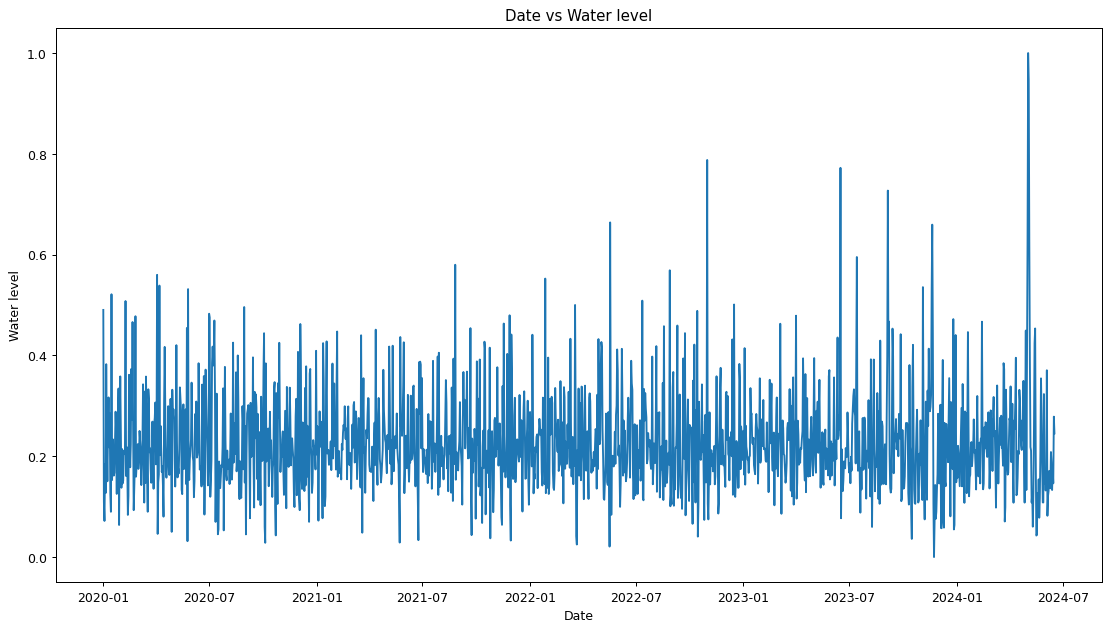

In [ ]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
start_date_train = '2023-01-01 00:15:00'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

In [ ]:
df_train

,level_cm_lag_1_scaled
date_time,
2020-01-02,0.490339
2020-01-03,0.109059
2020-01-04,0.071649
2020-01-05,0.184804
2020-01-06,0.126990
...,...
2022-12-28,0.259004
2022-12-29,0.243933
2022-12-30,0.199722


In [ ]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-03,0.414515
2023-01-04,0.143685
2023-01-05,0.260550
2023-01-06,0.219045
2023-01-07,0.210079
...,...
2024-06-12,0.133019
2024-06-13,0.175452
2024-06-14,0.146313


## AUTO ARIMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1,
                   start_q=1,
                   max_p=2,
                   max_q=2,
                   start_P=1,
                   start_Q=1,
                   D=0,
                   max_P=3,
                   max_D=3,
                   max_Q=3,
                   max_order=5,
                   m=365,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1301.455, Time=0.31 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-1612.500, Time=3.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-1303.455, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-1299.866, Time=0.35 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-1736.546, Time=4.53 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=-1788.269, Time=12.55 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=21.13 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.55 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=-1790.115, Time=9.34 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-1738.333, Time=3.98 sec
 ARIMA(0,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=16.81 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.20 sec
 ARIMA(0,0,1)(3,1,0)[12] intercept   

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

2023-01-02    0.227578
2023-01-03    0.213113
2023-01-04    0.195025
2023-01-05    0.167477
2023-01-06    0.264570
                ...   
2024-06-11    0.182972
2024-06-12    0.224585
2024-06-13    0.227183
2024-06-14    0.199592
2024-06-15    0.187593
Freq: D, Length: 531, dtype: float64

In [ ]:
forecast.values

array([0.22757763, 0.21311281, 0.19502481, 0.16747741, 0.26456977,
       0.22530307, 0.21283224, 0.32823314, 0.25629345, 0.17322355,
       0.18636535, 0.21911151, 0.22651465, 0.19690913, 0.19269015,
       0.1666222 , 0.30929628, 0.25391307, 0.2062975 , 0.33166917,
       0.23400138, 0.1731878 , 0.18251898, 0.21543095, 0.22827187,
       0.20085656, 0.191327  , 0.16700739, 0.34207534, 0.24253529,
       0.18355844, 0.34919637, 0.2190278 , 0.1681218 , 0.17964413,
       0.2282047 , 0.22662145, 0.19700739, 0.18092351, 0.16091809,
       0.32308885, 0.26485852, 0.19481972, 0.31996084, 0.23755133,
       0.17751812, 0.18486915, 0.2273721 , 0.2272321 , 0.20146213,
       0.18960969, 0.16534388, 0.31206918, 0.24775176, 0.19857396,
       0.33233679, 0.23583115, 0.17304676, 0.18323338, 0.22285597,
       0.22717378, 0.19915849, 0.18841098, 0.16486548, 0.32180064,
       0.25229114, 0.19553187, 0.33310785, 0.23173048, 0.17303518,
       0.18262166, 0.22376987, 0.22728885, 0.19959818, 0.18750

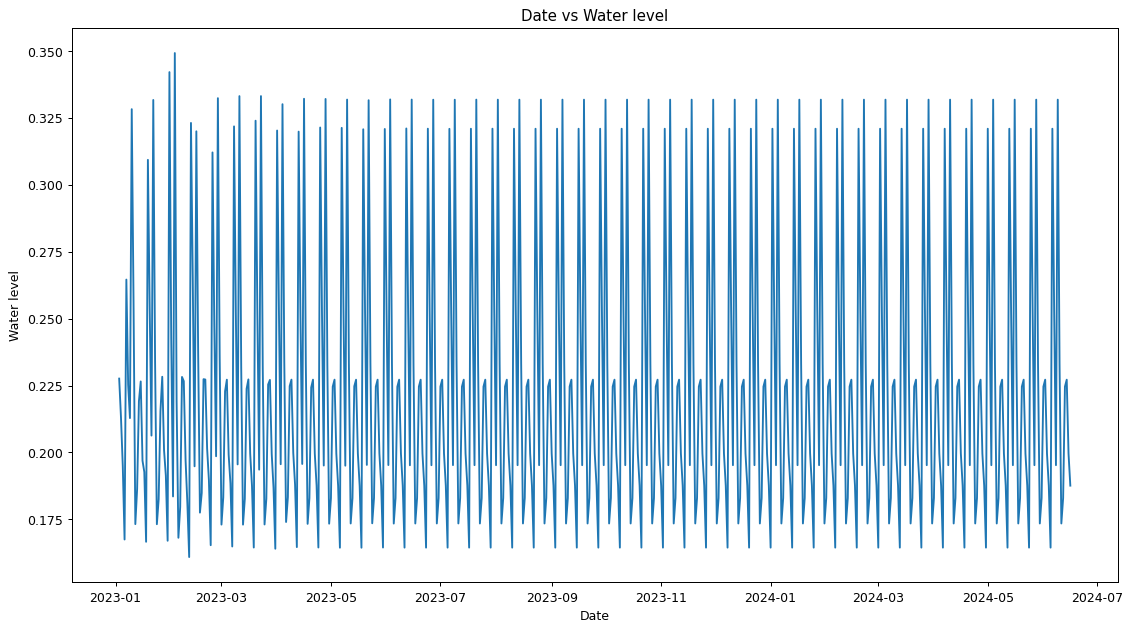

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

Text(0.5, 1.0, 'Forecast using AutoReg - Train')

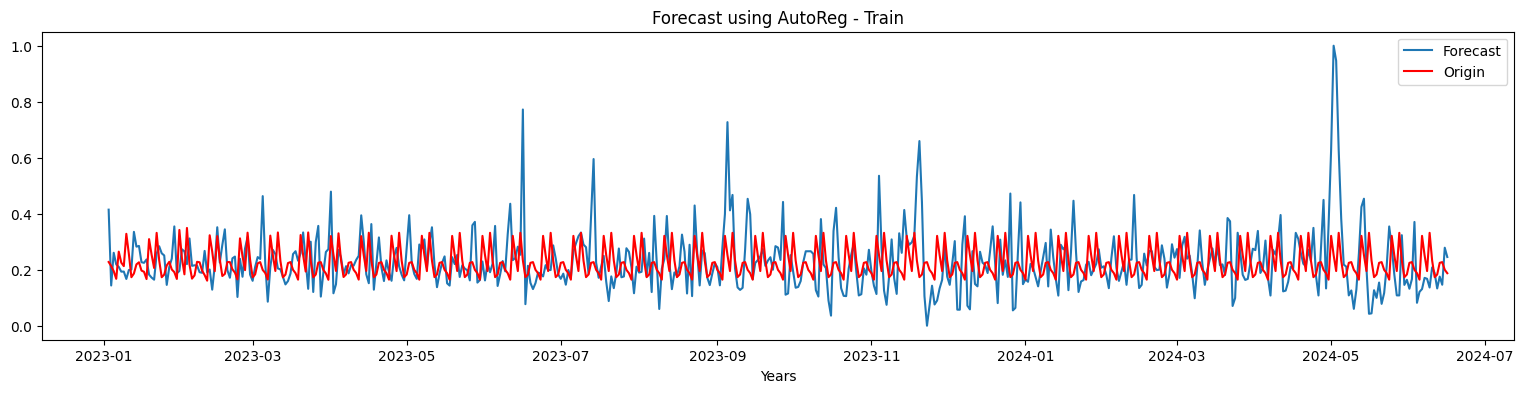

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['level_cm_lag_1_scaled'])
plt.plot(df_test.index, forecast.values, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Undoing the scale transformation

In [ ]:
forecast = forecast.values
test_data = np.array(df_test['level_cm_lag_1_scaled'])

forecast_inversed = scaler.inverse_transform(forecast.reshape(-1, 1))
test_inversed = scaler.inverse_transform(test_data.reshape(-1, 1))

Text(0.5, 1.0, 'Forecast using ARIMA - Test')

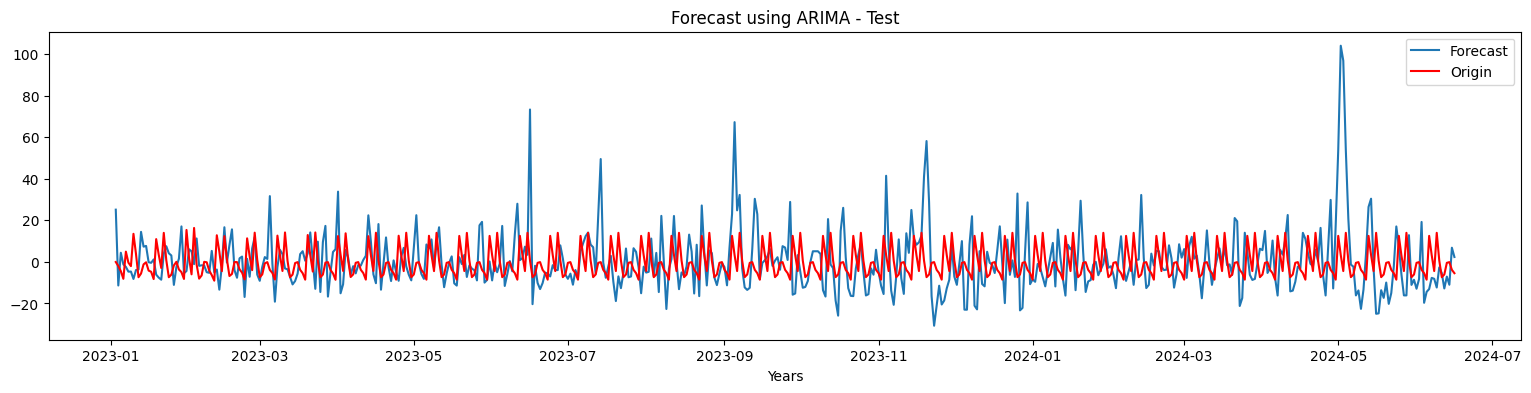

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, test_inversed)
plt.plot(df_test.index, forecast_inversed, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Calculating error

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
print("MSE: ", mean_squared_error(test_inversed, forecast_inversed))

MSE:  255.80939052355836


In [ ]:
print("RMSE: ", root_mean_squared_error(test_inversed, forecast_inversed))

RMSE:  15.994042344684422
